# This is a method of converting the detected image into HSV space to classify a traffic light

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from glob import glob
%matplotlib inline

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
# Downloading the pre-trained model
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph.
model_path = "./"
PATH_TO_CKPT = model_path + MODEL_NAME + '/frozen_inference_graph.pb'


def download_model():
    import six.moves.urllib as urllib
    import tarfile

    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
        file_name = os.path.basename(file.name)
        if 'frozen_inference_graph.pb' in file_name:
            tar_file.extract(file, os.getcwd())

In [5]:
def load_graph():
    if not os.path.exists(PATH_TO_CKPT):
        download_model()

    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    return detection_graph

def select_boxes(boxes, classes, scores, score_threshold=0, target_class=10):
    """

    :param boxes:
    :param classes:
    :param scores:
    :param target_class: default traffic light id in COCO dataset is 10
    :return:
    """

    sq_scores = np.squeeze(scores)
    sq_classes = np.squeeze(classes)
    sq_boxes = np.squeeze(boxes)

    sel_id = np.logical_and(sq_classes == target_class, sq_scores > score_threshold)

    return sq_boxes[sel_id]

class TLClassifier(object):
    def __init__(self):

        self.detection_graph = load_graph()
        self.extract_graph_components()
        self.sess = tf.Session(graph=self.detection_graph)

        # run the first session to "warm up"
        dummy_image = np.zeros((100, 100, 3))
        self.detect_multi_object(dummy_image,0.1)
        self.traffic_light_box = None
        self.classified_index = 0

    def extract_graph_components(self):
        # Definite input and output Tensors for detection_graph
        self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
        self.num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')
    
    def detect_multi_object(self, image_np, score_threshold):
        """
        Return detection boxes in a image

        :param image_np:
        :param score_threshold:
        :return:
        """

        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.

        (boxes, scores, classes, num) = self.sess.run(
            [self.detection_boxes, self.detection_scores, self.detection_classes, self.num_detections],
            feed_dict={self.image_tensor: image_np_expanded})

        sel_boxes = select_boxes(boxes=boxes, classes=classes, scores=scores,
                                 score_threshold=score_threshold, target_class=10)

        return sel_boxes

In [6]:
%time
test_file = "dayClip6--00123.jpg"

from PIL import Image
im = Image.open(test_file)
image_np = np.asarray(im)

Wall time: 0 ns


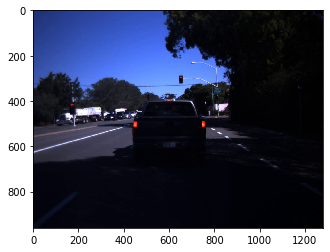

In [7]:
plt.imshow(image_np)

In [8]:
tlc=TLClassifier()

In [9]:
def crop_roi_image(image_np, sel_box):
    im_height, im_width, _ = image_np.shape
    (left, right, top, bottom) = (sel_box[1] * im_width, sel_box[3] * im_width,
                                  sel_box[0] * im_height, sel_box[2] * im_height)
    cropped_image = image_np[int(top):int(bottom), int(left):int(right), :]
    return cropped_image

Wall time: 0 ns


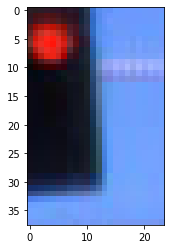

In [10]:
%time
boxes=tlc.detect_multi_object(image_np,score_threshold=0.2)
cropped_image=crop_roi_image(image_np,boxes[0])
plt.imshow(cropped_image)

In [11]:
from skimage.color import rgb2grey,rgb2hsv
hsv_test_image=rgb2hsv(cropped_image)

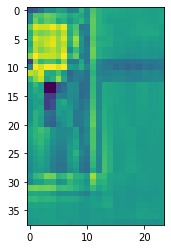

In [12]:
plt.imshow(hsv_test_image[:,:,1])

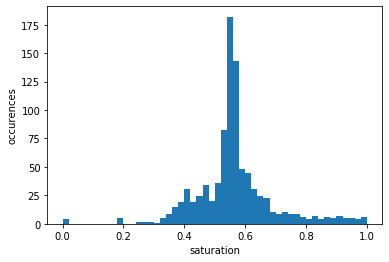

In [13]:
s_val_1d=hsv_test_image[:,:,1].ravel()
plt.hist(s_val_1d,bins=50)
plt.xlabel("saturation")
plt.ylabel("occurences")
plt.show()

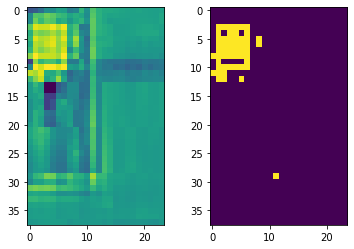

In [14]:
saturation_threshold=0.8
idx = hsv_test_image[:, :, 1] <=saturation_threshold
sat_mask = np.ones_like(hsv_test_image[:, :, 1])
sat_mask[idx] = 0
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].imshow(hsv_test_image[:,:,1])
ax[1].imshow(sat_mask)

In [15]:
def high_value_region_mask(hsv_image, v_thres=0.6):
    if hsv_image.dtype == np.int:
        idx = (hsv_image[:, :, 2].astype(np.float) / 255.0) < v_thres
    else:
        idx = (hsv_image[:, :, 2].astype(np.float)) < v_thres
    mask = np.ones_like(hsv_image[:, :, 2])
    mask[idx] = 0
    return mask

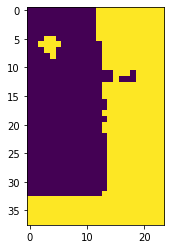

In [16]:
v_thres_val=0.9
val_mask=high_value_region_mask(hsv_test_image,v_thres=v_thres_val)
plt.imshow(val_mask)

In [17]:
def get_masked_hue_image(hsv_test_image):

    s_thres_val = channel_percentile(hsv_test_image[:, :, 1], percentile=70)
    v_thres_val = channel_percentile(hsv_test_image[:, :, 2], percentile=70)
    val_mask = high_value_region_mask(hsv_test_image, v_thres=v_thres_val)
    sat_mask = high_saturation_region_mask(hsv_test_image, s_thres=s_thres_val)
    masked_hue_image = hsv_test_image[:, :, 0]
    return masked_hue_image

In [18]:
def high_saturation_region_mask(hsv_image, s_thres=0.6):
    if hsv_image.dtype == np.int:
        idx = (hsv_image[:, :, 1].astype(np.float) / 255.0) < s_thres
    else:
        idx = (hsv_image[:, :, 1].astype(np.float)) < s_thres
    mask = np.ones_like(hsv_image[:, :, 1])
    mask[idx] = 0
    return mask


def channel_percentile(single_chan_image, percentile):
    sq_image = np.squeeze(single_chan_image)
    assert len(sq_image.shape) < 3

    thres_value = np.percentile(sq_image.ravel(), percentile)

    return float(thres_value) / 255.0

Text(0.5, 1.0, 'mask to be applied')

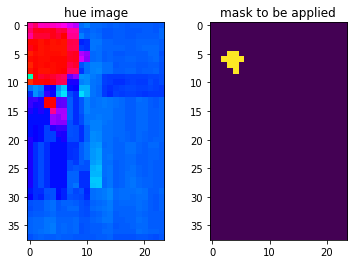

In [19]:
hue_image=hsv_test_image[:,:,0]
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].imshow(hue_image,cmap='hsv')
ax[0].set_title("hue image")
ax[1].imshow(np.logical_and(sat_mask,val_mask))
ax[1].set_title("mask to be applied")

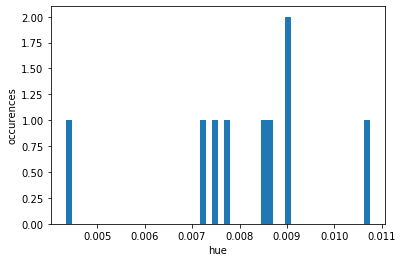

In [20]:
hue_1d=hue_image[np.logical_and(val_mask, sat_mask)].ravel()

plt.hist(hue_1d,bins=50)
plt.xlabel("hue")
plt.ylabel("occurences")
plt.show()

In [21]:
def get_masked_hue_values(rgb_image):
    """
    Get the pixels in the RGB image that has high saturation (S) and value (V) in HSV chanels

    :param rgb_image: image (height, width, channel)
    :return: a 1-d array
    """

    hsv_test_image = rgb2hsv(rgb_image)
    s_thres_val = channel_percentile(hsv_test_image[:, :, 1], percentile=30)
    v_thres_val = channel_percentile(hsv_test_image[:, :, 2], percentile=70)
    val_mask = high_value_region_mask(hsv_test_image, v_thres=v_thres_val)
    sat_mask = high_saturation_region_mask(hsv_test_image, s_thres=s_thres_val)
    masked_hue_image = hsv_test_image[:, :, 0] * 180
    # Note that the following statement is not equivalent to
    # masked_hue_1d= (maksed_hue_image*np.logical_and(val_mask,sat_mask)).ravel()
    # Because zero in hue channel means red, we cannot just set unused pixels to zero.
    masked_hue_1d = masked_hue_image[np.logical_and(val_mask, sat_mask)].ravel()

    return masked_hue_1d

def convert_to_hue_angle(hue_array):
    """
    Convert the hue values from [0,179] to radian degrees [-pi, pi]

    :param hue_array: array-like, the hue values in degree [0,179]
    :return: the angles of hue values in radians [-pi, pi]
    """

    hue_cos = np.cos(hue_array * np.pi / 90)
    hue_sine = np.sin(hue_array * np.pi / 90)

    hue_angle = np.arctan2(hue_sine, hue_cos)

    return hue_angle

In [22]:
def get_rgy_color_mask(hue_value, from_01=False):
    """
    return a tuple of np.ndarray that sets the pixels with red, green and yellow matrices to be true

    :param hue_value:
    :param from_01: True if the hue values is scaled from 0-1 (scikit-image), otherwise is -pi to pi
    :return:
    """

    if from_01:
        n_hue_value = conver_to_hue_angle_from_01(hue_value)
    else:
        n_hue_value = hue_value

    red_index = np.logical_and(n_hue_value < (0.125 * np.pi), n_hue_value > (-0.125 * np.pi))

    green_index = np.logical_and(n_hue_value > (0.66 * np.pi), n_hue_value < np.pi)

    yellow_index = np.logical_and(n_hue_value > (0.25 * np.pi), n_hue_value < (5.0 / 12.0 * np.pi))

    return red_index, green_index, yellow_index


def classify_color_by_range(hue_value):
    """
    Determine the color (red, yellow or green) in a hue value array

    :param hue_value: hue_value is radians
    :return: the color index ['red', 'yellow', 'green', '_', 'unknown']
    """

    red_index, green_index, yellow_index = get_rgy_color_mask(hue_value)

    color_counts = np.array([np.sum(red_index) / len(hue_value),
                             np.sum(yellow_index) / len(hue_value),
                             np.sum(green_index) / len(hue_value)])

    color_text = ['red', 'yellow', 'green', '_', 'unknown']

    min_index = np.argmax(color_counts)

    return min_index, color_text[min_index]

def classify_color_cropped_image(rgb_image):
    """
    Full pipeline of classifying the traffic light color from the traffic light image

    :param rgb_image: the RGB image array (height,width, RGB channel)
    :return: the color index ['red', 'yellow', 'green', '_', 'unknown']
    """

    hue_1d_deg = get_masked_hue_values(rgb_image)

    if len(hue_1d_deg) == 0:
        return 4, 'unknown'

    hue_1d_rad = convert_to_hue_angle(hue_1d_deg)

    return classify_color_by_range(hue_1d_rad)

# With this the traffic light is detected and also classified

In [23]:
classify_color_cropped_image(cropped_image)

(0, 'red')